# Evaluation for LSTM model

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
import pickle

# Input data files are available in the "./input_data/" directory.
import os
print(os.listdir("./input_data/final"))
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.tools.plotting import table

###################################
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k

# TensorFlow wizardry
config = tf.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.1
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))
###################################

Using TensorFlow backend.


['clean_train.csv', 'no_duplicates']


## Defining functions

In [2]:
# Setting up tokenizer
n_most_common_words = 1000 #8000
max_len = 150

# This function should only be called once
def initializeTokenizer(trainingDF):
    tokenizer.fit_on_texts(trainingDF['OPCODE'].values)
    # Saving tokenizer
    import pickle
    with open('./PickleJar/'+modelName+'_tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

def label(df):    
    # label data
    df['LABEL'] = 0
    df.loc[df['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
    df.loc[df['CATEGORY'] != '1 0 0 0', 'LABEL'] = 1
    
def preprocess(df):
    # # Transforms each text in texts in a sequence of integers.
    sequences = tokenizer.texts_to_sequences(df['OPCODE'].values)
    # sequences = tokenizer.texts_to_sequences(tt)

    #Find number of unique words/tokens
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    #pad sequences with zeros in front to make them all maxlen
    X = pad_sequences(sequences, maxlen=max_len)
    return X

def dftoXY(df):
    # Save test X and y
    X_test = preprocess(df)
    # label data
    label(df)
    print(pd.value_counts(df['LABEL']))
    y_test = to_categorical(df['LABEL'], num_classes=2)
    return X_test, y_test    

def XandY(posdf, negdf):
    dfset = pd.concat([posdf, negdf])
    dfset = dfset.sample(frac=1, random_state=39, replace=False)

    dfset['LABEL'] = 0

    #One-hot encode the lab
    dfset.loc[dfset['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
    dfset.loc[dfset['CATEGORY'] != '1 0 0 0', 'LABEL'] = 1
    # df_train.head()

    X, y = dftoXY(dfset)

    print('Shape of X: {}'.format(X.shape))

    # for sm.fit_sample
    y_labels = np.expand_dims(np.array(np.argmax(y, axis=1)), axis=1)
    print('Shape of y: {}'.format(y_labels.shape))

    return X, y_labels

In [3]:
# ============== Set and Tune ============== 
# ========================================== 

# os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used
# split positives dataset into train, val, and test
proportion_train = 0.64 #0.7 
proportion_val = 0.16 #0.1 
proportion_test = 0.2 #0.20

# set number of samples in each set
trainSize = 550000 #350000 #30000 #11000

# Init
epochs = 80
emb_dim = 128 #150
batch_size = 256 #512   

# LSTM Model
# tune Dropout(0.6) and LSTM 64 or 32
ratioFP = 0.5
FPtrain_frac = 0.8
dropout = 0.5
LSTM_units = 64

# Model name:
modelName = 'V5-FYP-v2'

## Saving and Loading Trained Model

In [4]:
# model_name = "v3_550KLSTM64epoch100train0.64drop0.55"
modelName = 'V5-FYP-v2'

In [5]:
with open('./PickleJar/'+modelName+'_tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [6]:
# loading previously saved model
from keras.models import load_model
# model = load_model('./saved_model/postreviewV3/'+ 'train' + model_name + '.h5')
model = load_model('./SavedModels/'+modelName+'.h5')   

## Plot Performance

In [7]:
# infile = open('./saved_model/postreviewV3/' + 'train' + model_name ,'rb')
infile = open('./PickleJar/' + 'train' + modelName, 'rb')
history0 = pickle.load(infile)
infile.close()

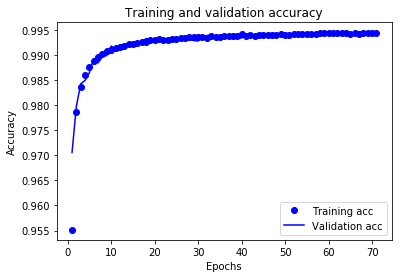

In [8]:
# acc = history.history['acc']
# val_acc = history.history['val_acc']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

acc = history0['acc']
val_acc = history0['val_acc']
loss = history0['loss']
val_loss = history0['val_loss']


epochs = range(1, len(acc) + 1)

fig = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# fig.savefig('./figures/postreviewV4.1/Accr_trainandval_' + model_name + '.png',dpi=300)

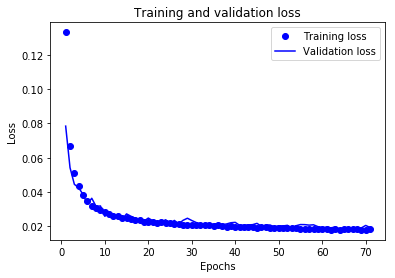

In [9]:
fig = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
# fig.savefig('./figures/postreviewV4.1/Loss_trainandval_' + model_name + '.png',dpi=300)

This happens when you use Dropout, since the behaviour when training and testing are different.

When training, a percentage of the features are set to zero (50% in my case). When testing, all features are used (and are scaled appropriately). So the model at test time is more robust - and can lead to higher testing accuracies.

No signs of over or under fitting. 

## All test FPs

**Loading the dataset**

In [10]:
# Loading and reading csv input data 

# all_testset = 'clean_test_allFP_noDups.csv'
leakFP = 'clean_test_leakFP_noDups.csv'
suicidalFP = 'clean_test_suicidalFP_noDups.csv'
greedyFP = 'clean_test_greedyFP_noDups.csv'

leakFP_test = pd.read_csv('./input_data/final/no_duplicates/'+leakFP, usecols=['ADDRESS', 'OPCODE', 'CATEGORY'])
suicidalFP_test = pd.read_csv('./input_data/final/no_duplicates/'+suicidalFP, usecols=['ADDRESS', 'OPCODE', 'CATEGORY'])
greedyFP_test = pd.read_csv('./input_data/final/no_duplicates/'+greedyFP, usecols=['ADDRESS', 'OPCODE', 'CATEGORY'])

# leakFP_test.head()

In [11]:
X_leakFP, y_leakFP = dftoXY(leakFP_test)
leakFP_accr = model.evaluate(X_leakFP,y_leakFP)
print('Leak test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(leakFP_accr[0],leakFP_accr[1]))

X_suicidalFP, y_suicidalFP = dftoXY(suicidalFP_test)
suicidalFP_accr = model.evaluate(X_suicidalFP,y_suicidalFP)
print('Suicidal test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(suicidalFP_accr[0],suicidalFP_accr[1]))

X_greedyFP, y_greedyFP = dftoXY(greedyFP_test)
greedyFP_accr = model.evaluate(X_greedyFP,y_greedyFP)
print('Greedy test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(greedyFP_accr[0],greedyFP_accr[1]))

Found 150 unique tokens.
0    177
Name: LABEL, dtype: int64
177/177 [==============================] - 0s 1ms/step
Leak test set
  Loss: 1.0850
  Accuracy: 0.7401
Found 150 unique tokens.
0    72
Name: LABEL, dtype: int64
72/72 [==============================] - 0s 499us/step
Suicidal test set
  Loss: 1.1527
  Accuracy: 0.4444
Found 150 unique tokens.
0    202
Name: LABEL, dtype: int64
202/202 [==============================] - 0s 484us/step
Greedy test set
  Loss: 1.9171
  Accuracy: 0.4158


# ADDED Evaluation Measures

### Saving and Loading Trained Model

In [12]:
# ===============================================================#
# ============== Loading and reading csv input data =============# 
# ===============================================================#
dataset = 'clean_train.csv'
data = pd.read_csv('./input_data/final/'+dataset, usecols=['ADDRESS', 'OPCODE', 'CATEGORY'])

shuffled = data

n = shuffled[shuffled['CATEGORY'] == '1 0 0 0'] # no vulnerabilities
s = shuffled[shuffled['CATEGORY'] == '0 1 0 0'] # suicidal
p = shuffled[shuffled['CATEGORY'] == '0 0 1 0'] # prodigal
g = shuffled[shuffled['CATEGORY'] == '0 0 0 1'] # greedy
sp = shuffled[shuffled['CATEGORY'] == '0 1 1 0'] # suicidal and prodigal

concated = pd.concat([n,s,p,g,sp], ignore_index=True)

#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

#One-hot encode the lab
concated.loc[concated['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
concated.loc[concated['CATEGORY'] != '1 0 0 0', 'LABEL'] = 1


# ========== set of vul contracts ========== 
# shuffle positives dataset
positives = pd.concat([s,p,g,sp])
positives_shuf = positives.sample(frac=1, random_state=39, replace=False)

num_pos_train = round(len(positives_shuf) * proportion_train)
num_pos_val = round(len(positives_shuf) * proportion_val)

pos_train = positives_shuf.iloc[0:num_pos_train] 
pos_val = positives_shuf.iloc[num_pos_train:(num_pos_train+num_pos_val)]
pos_test = positives_shuf.iloc[(num_pos_train+num_pos_val):]

print("Total number of vulnerable contracts (positives_shuf): "+str(len(positives_shuf)))
print("Train \t\tpos_train: \t\t"+str(len(pos_train)))
print("Validation \tpos_val: \t\t"+str(len(pos_val)))
print("Test \t\tpos_test: \t\t"+str(len(pos_test)))


# ========== set of non-vul contracts ========== 
# # shuffle set n
n_shuf = n.sample(frac=1, random_state=39, replace=False)

# # set number of samples in each set
num_neg_train = 550000
print(num_neg_train)
# set number of samples in each set
num_neg_train = round(num_neg_train*0.5) #30000 #11000
num_neg_val = round(((trainSize)/proportion_train)*proportion_val)
num_neg_test = round(((trainSize)/proportion_train)*proportion_test)

neg_train = n_shuf.iloc[0:num_neg_train]
neg_val = n_shuf.iloc[num_neg_train:(num_neg_train+num_neg_val)]
neg_test = n_shuf.iloc[(num_neg_train+num_neg_val):(num_neg_train+num_neg_val+num_neg_test)]
neg_notused = n_shuf.iloc[(num_neg_train+num_neg_val+num_neg_test):]

print("Number of negative samples not used: ", len(neg_notused))
print("Total number of non-vulnerable contracts (n_shuf): "+str(len(n_shuf)))
print("Train \t\tneg_train: \t\t"+str(len(neg_train)))
print("Validation \tneg_val: \t\t"+str(len(neg_val)))
print("Test \t\tneg_test: \t\t"+str(len(neg_test)))

### ============ Resampling samples ============ ###
# Prepare train set 
#X_train, ytrain_labels = XandY(pos_train, neg_train)
# Join training set together and shuffle
df_train = pd.concat([pos_train, neg_train])
df_train = df_train.sample(frac=1, random_state=39, replace=False)

# One-hot encode the lab
df_train['LABEL'] = 0
df_train.loc[df_train['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
df_train.loc[df_train['CATEGORY'] != '1 0 0 0', 'LABEL'] = 1
# df_train.head()

# Initialize tokenizer with training set 
# initializeTokenizer(df_train)

# Get train & target vectors 
X_train, y_train = dftoXY(df_train)
print('Shape of X: {}'.format(X_train.shape))

# for sm.fit_sample
ytrain_labels = np.expand_dims(np.array(np.argmax(y_train, axis=1)), axis=1)
print('Shape of y: {}'.format(ytrain_labels.shape))

## Prepare validation set 
#X_val, yval_labels = XandY(pos_val, neg_val)
df_val = pd.concat([pos_val, neg_val])
df_val = df_val.sample(frac=1, random_state=39, replace=False)

df_val['LABEL'] = 0

#One-hot encode the lab
df_val.loc[df_val['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
df_val.loc[df_val['CATEGORY'] != '1 0 0 0', 'LABEL'] = 1
# df_train.head()

X_val, y_val = dftoXY(df_val)

print('Shape of X: {}'.format(X_val.shape))

# for sm.fit_sample
yval_labels = np.expand_dims(np.array(np.argmax(y_val, axis=1)), axis=1)
print('Shape of y: {}'.format(yval_labels.shape))

# Prepare test set 
#X_test, ytest_labels = XandY(pos_test, neg_test)
# ============ test set ============ 
df_test = pd.concat([pos_test, neg_test])
df_test = df_test.sample(frac=1, random_state=39, replace=False)

df_test['LABEL'] = 0

#One-hot encode the lab
df_test.loc[df_test['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
df_test.loc[df_test['CATEGORY'] != '1 0 0 0', 'LABEL'] = 1
# df_train.head()

X_test, y_test = dftoXY(df_test)

print('Shape of X: {}'.format(X_test.shape))

# for sm.fit_sample
ytest_labels = np.expand_dims(np.array(np.argmax(y_test, axis=1)), axis=1)
print('Shape of y: {}'.format(ytest_labels.shape))

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", ytrain_labels.shape)
print("Number transactions X_val dataset: ", X_val.shape)
print("Number transactions y_val dataset: ", yval_labels.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", ytest_labels.shape)

print("Before OverSampling, counts of label '1': {}".format(sum(ytrain_labels==1)))
print("Before OverSampling, counts of label '0': {}".format(sum(ytrain_labels==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(yval_labels==1)))
print("Before OverSampling, counts of label '0': {}".format(sum(yval_labels==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(ytest_labels==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(ytest_labels==0)))


# ============ Resample ============ 
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=39)
X_train_res, y_train_res = sm.fit_sample(X_train, ytrain_labels.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {}'.format(y_train_res.shape))

print("After OverSampling, counts of train label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of train label '0': {}".format(sum(y_train_res==0)))


# ============== LSTM Model ==============
# # Init
# # ------------------
# # ------ tune ------
# epochs = 1 #70 #50 #100
# emb_dim = 128 #150
# batch_size = 256 #512
# # ------------------
# # ------------------

# Convert format for training  
ytrainres_cat = to_categorical(y_train_res, num_classes=2)
yvalres_cat = to_categorical(yval_labels, num_classes=2)
ytestres_cat = to_categorical(ytest_labels, num_classes=2)

#print((X_train_res.shape, ytrainres_cat.shape, X_val_res.shape, yvalres_cat.shape, X_test_res.shape, ytestres_cat.shape))
print((X_train_res.shape, ytrainres_cat.shape, X_val.shape, yvalres_cat.shape, X_test.shape, ytestres_cat.shape))

Total number of vulnerable contracts (positives_shuf): 8640
Train 		pos_train: 		5530
Validation 	pos_val: 		1382
Test 		pos_test: 		1728
550000
Number of negative samples not used:  299898
Total number of non-vulnerable contracts (n_shuf): 884273
Train 		neg_train: 		275000
Validation 	neg_val: 		137500
Test 		neg_test: 		171875
Found 150 unique tokens.
0    275000
1      5530
Name: LABEL, dtype: int64
Shape of X: (280530, 150)
Shape of y: (280530, 1)
Found 150 unique tokens.
0    137500
1      1382
Name: LABEL, dtype: int64
Shape of X: (138882, 150)
Shape of y: (138882, 1)
Found 150 unique tokens.
0    171875
1      1728
Name: LABEL, dtype: int64
Shape of X: (173603, 150)
Shape of y: (173603, 1)
Number transactions X_train dataset:  (280530, 150)
Number transactions y_train dataset:  (280530, 1)
Number transactions X_val dataset:  (138882, 150)
Number transactions y_val dataset:  (138882, 1)
Number transactions X_test dataset:  (173603, 150)
Number transactions y_test dataset:  (1736

In [13]:
# Test accuracy
accr = model.evaluate(X_test, ytestres_cat)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))

173603/173603 [==============================] - 85s 488us/step
Test set
  Loss: 0.0195
  Accuracy: 0.9942


In [14]:
# To calculate precision and recall
# y_pred = model.predict_classes(X_test_res, batch_size=32, verbose=0)
y_pred = model.predict_classes(X_test, batch_size=32, verbose=0)
# ytest_true = y_test_res
ytest_true = ytest_labels

In [15]:
from sklearn.metrics import average_precision_score
# Compute the average precision score
average_precision = average_precision_score(ytest_true, y_pred)
print('Average Precision Score: {:0.4f}\n'.format(average_precision))

# Compute the recall
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(ytest_true, y_pred)
print('Recall Score: {:0.4f}\n'.format(recall[1]))

print("============== ADDED Evaluation ==============")
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

# The set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
print('Accuracy: {:0.4f}\n'.format(accuracy_score(ytest_true, y_pred)))
# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
print('Recall: {:0.4f}\n'.format(recall_score(ytest_true, y_pred)))
# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
print('Precision: {:0.4f}\n'.format(precision_score(ytest_true, y_pred)))
# The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
print('F1 score: {:0.4f}\n'.format(f1_score(ytest_true, y_pred)))

# In binary classification, the count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}.
print('\n confusion matrix:\n',confusion_matrix(ytest_true, y_pred))
# Overview of all scores
print('\n clasification report:\n', classification_report(ytest_true, y_pred))

Average Precision Score: 0.5867

Recall Score: 0.8987

============== ADDED Evaluation ==============
Accuracy: 0.9942

Recall: 0.8987

Precision: 0.6517

F1 score: 0.7555


 confusion matrix:
 [[171045    830]
 [   175   1553]]

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    171875
           1       0.65      0.90      0.76      1728

   micro avg       0.99      0.99      0.99    173603
   macro avg       0.83      0.95      0.88    173603
weighted avg       1.00      0.99      0.99    173603



In [16]:
from sklearn.metrics import roc_curve, auc, roc_auc_score    
# Compute Receiver operating characteristic (ROC). Restricted to the binary classification task
fpr, tpr, threshold = roc_curve(ytest_true, y_pred)
roc_auc = auc(fpr, tpr)
print('ROC AUC score: {:0.4f}\n'.format(roc_auc_score(ytest_true, y_pred)))

ROC AUC score: 0.9469



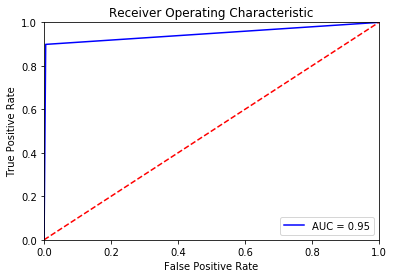

In [17]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
## plt.show()
plt.savefig('ROC_' + modelName + '.png', dpi=300)

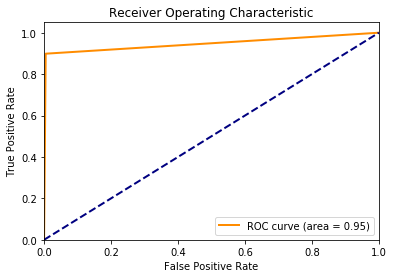

In [18]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
## plt.show()
plt.savefig('ROCnice_' + modelName + '.png',dpi=300)

In [20]:
# trend_df = pd.read_csv('results-20190304-132710.csv')
trend_df = pd.read_csv('results-20190304-134307.csv')

In [21]:
trend_df.head()

,noOfContracts,month,year
0,741,8,2015
1,1086,9,2015
2,1511,10,2015
3,1243,11,2015
4,1606,12,2015


In [22]:
def getMonthYear (row):
   return str(row['month'])+" "+str(row['year'])

trend_df.apply (lambda row: getMonthYear (row),axis=1)

0      8 2015
1      9 2015
2     10 2015
3     11 2015
4     12 2015
5      1 2016
6      2 2016
7      3 2016
8      4 2016
9      5 2016
10     6 2016
11     7 2016
12     8 2016
13     9 2016
14    10 2016
15    11 2016
16    12 2016
17     1 2017
18     2 2017
19     3 2017
20     4 2017
21     5 2017
22     6 2017
23     7 2017
24     8 2017
25     9 2017
26    10 2017
27    11 2017
28    12 2017
29     1 2018
30     2 2018
31     3 2018
32     4 2018
33     5 2018
34     6 2018
35     7 2018
36     8 2018
37     9 2018
38    10 2018
39    11 2018
40    12 2018
dtype: object

In [23]:
trend_df['year-month'] = trend_df.apply (lambda row: getMonthYear (row),axis=1)

<Figure size 1296x576 with 0 Axes>

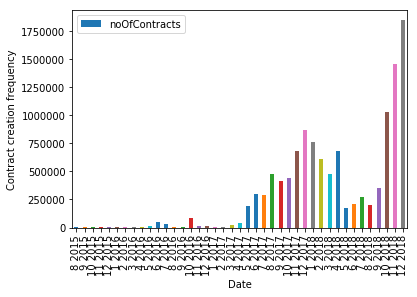

In [24]:
fig = plt.figure()
trend_df.plot(kind='bar',x='year-month',y='noOfContracts')
fig.set_size_inches(18, 8)
plt.xlabel("Date")
plt.ylabel("Contract creation frequency")
plt.savefig('contract_creation.png', dpi=300, bbox_inches="tight") #, bbox_inches='tight'
plt.show()